# Instructor Do: Create and Deploy a Machine Learning Model in Amazon SageMaker

In [1]:
# Initial imports
import os
import io
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Amazon SageMaker and related imports
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker.predictor import csv_serializer, json_deserializer
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import boto3  # AWS Python sdk

%matplotlib inline

## Reading Data

In [2]:
# Read the weather features data
file_path = Path("Data/x_austin_final.csv")
features = pd.read_csv(file_path)

# Transforming the "TempAvgF" column to a vector
X = features["TempAvgF"].values.reshape(-1, 1)

In [3]:
# Read the target data (precipitation sum inches)
file_path = Path("Data/y_austin_final.csv")
y = pd.read_csv(file_path, names=["PrecipitationSumInches"], header=None)

# Transforming y into a vector
y = y.iloc[:, 0].values

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Creating the Linear Regression Model

### Initial Configurations

In [5]:
# Define Amazon S3 Bucket to store model data
bucket = "sagemaker-07132021"  #'<your_s3_bucket_name_here>'

# Define prefix for data files
prefix = "austin-rainfall-regression"

# AWS IAM role
role = get_execution_role()

### Uploading Training Data to Amazon S3

In [6]:
# Encode the training data as Protocol Buffer
buf = io.BytesIO()
vectors = np.array(X_train).astype("float32")
labels = np.array(y_train).astype("float32")
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)

# Upload encoded training data to Amazon S3
key = "linear_train.data"
boto3.resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train", key)
).upload_fileobj(buf)
s3_train_data = "s3://{}/{}/train/{}".format(bucket, prefix, key)
print("Training data uploaded to: {}".format(s3_train_data))

Training data uploaded to: s3://sagemaker-07132021/austin-rainfall-regression/train/linear_train.data


### Upload Test Data to Amazon S3

In [7]:
# Encode the testing data as Protocol Buffer
buf = io.BytesIO()
vectors = np.array(X_test).astype("float32")
labels = np.array(y_test).astype("float32")
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)

# Upload encoded testing data to Amazon S3
key = "linear_test.data"
boto3.resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "test", key)
).upload_fileobj(buf)
s3_test_data = "s3://{}/{}/test/{}".format(bucket, prefix, key)
print("Testing data uploaded to: {}".format(s3_test_data))

Testing data uploaded to: s3://sagemaker-07132021/austin-rainfall-regression/test/linear_test.data


### Creating Model Instance

In [8]:
# Create an instance of the linear learner algorithm
container = get_image_uri(boto3.Session().region_name, "linear-learner")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


In [9]:
# Start the Amazon SageMaker session
sess = sagemaker.Session()

# Create an instance of the linear learner estimator
linear = sagemaker.estimator.Estimator(
    container,
    role,
    train_instance_count=1,
    train_instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)

# Define linear learner hyperparameters
linear.set_hyperparameters(
    feature_dim=1,
    mini_batch_size=100,
    predictor_type="regressor",
    epochs=10,
    num_models=32,
    loss="absolute_loss",
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


## Training the Machine Learning Model

In [10]:
# Fitting the linear learner model with the training data
linear.fit({"train": s3_train_data, "test": s3_test_data})

2021-07-14 02:39:24 Starting - Starting the training job...
2021-07-14 02:39:25 Starting - Launching requested ML instancesProfilerReport-1626230363: InProgress
......
2021-07-14 02:40:39 Starting - Preparing the instances for training.........
2021-07-14 02:42:19 Downloading - Downloading input data...
2021-07-14 02:42:50 Training - Downloading the training image...
2021-07-14 02:43:19 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/14/2021 02:43:22 INFO 139715453159232] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method'

## Deploying the Model to Make Predictions

In [11]:
# An instance of the linear-learner predictor is created
linear_predictor = linear.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

---------------------!

In [12]:
# Linear predictor configurations
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

In [13]:
# Making some predictions using the test data.
result = linear_predictor.predict(X_test)
y_predictions = np.array([r["score"] for r in result["predictions"]])
y_predictions[:5]

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


array([-0.00085252, -0.00326807, -0.00353646, -0.00071832, -0.00044993])

## Model Evaluation

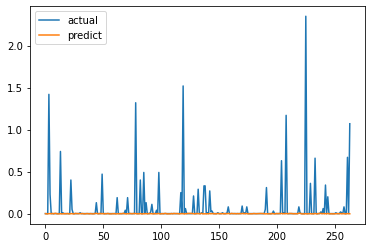

In [15]:
# Plotting predicted Vs. actual values
plt.plot(np.array(y_test), label="actual")
plt.plot(y_predictions, label="predict")
plt.legend()
plt.show()

In [16]:
# Calculating the RMSE and R2 scores
rmse = np.sqrt(mean_squared_error(y_test, y_predictions))
r2 = r2_score(y_test, y_predictions)

print("RMSE: {}".format(rmse))
print("R2 score: {}".format(r2))

RMSE: 0.26167106596926504
R2 score: -0.08068667064917312


## Delete Amazon SageMaker end-point

In [17]:
sagemaker.Session().delete_endpoint(linear_predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
